In [1]:
import numpy as np

import utils
from BenchmarkProblems.ToyAmalgam import ToyAmalgam
from BenchmarkProblems.OneMax import OneMax
import itertools

from BenchmarkProblems.RoyalRoad import RoyalRoad
from Core.get_pRef import get_pRef_from_metaheuristic

problem = RoyalRoad(5)

pRef = get_pRef_from_metaheuristic(problem=problem,
                                   sample_size=10000,
                                   which_algorithm="uniform GA",
                                   unique=True)

best_solution = pRef.get_best_solution()
print(pRef)

PRef with 5798 samples, mean = 2.12


In [2]:
from Core.FullSolution import FullSolution
from Core.SearchSpace import SearchSpace
import numpy as np

def every_var(search_space):
    return range(search_space.amount_of_parameters)

def every_pair_of_vars(search_space):
    return itertools.combinations(range(search_space.amount_of_parameters), r=2)

def every_value_for_var(var, search_space):
    return range(search_space.cardinalities[var])


def get_mutual_information_from_dicts(univariate_freq_dict, bivariate_freq_dict, search_space: SearchSpace):
    
    def mutual_information_for_values(a, b, va, vb):
        p_ab = bivariate_freq_dict[(a, b, va, vb)]
        p_a = univariate_freq_dict[(a, va)]
        p_b = univariate_freq_dict[(b, vb)]
        if p_ab == 0:
            return 0
        return p_ab * np.log(p_ab / (p_a * p_b))
    
    value_specific_mis = {(a, b, va, vb): mutual_information_for_values(a, b, va, vb)
                          for a, b in every_pair_of_vars(search_space)
                          for va in every_value_for_var(a, search_space)
                          for vb in every_value_for_var(b, search_space)
                          }
    
    def mutual_information_for_variable_pair(a, b):
        return sum(value_specific_mis[(a, b, va, vb)]
                   for va in every_value_for_var(a, search_space)
                   for vb in every_value_for_var(b, search_space))
    
    variable_mis = {(a, b): mutual_information_for_variable_pair(a, b) 
                    for a, b in every_pair_of_vars(search_space)}
    
    return value_specific_mis, variable_mis


def complete_linkage_table(linkage_table):
    n = linkage_table.shape[0]
    new_table = linkage_table + linkage_table.T
    sums_of_linkages = np.sum(new_table, axis=0)
    averages = sums_of_linkages / (n - 1)
    np.fill_diagonal(new_table, averages)
    return new_table


def linkage_table_from_mi_dict_for_vars(variable_mis, search_space: SearchSpace):
    n:int = search_space.amount_of_parameters
    linkage_table = np.zeros(shape=(n, n), dtype=float)
    for a, b in every_pair_of_vars(search_space):
        linkage_table[a, b] = variable_mis[a, b]
    
    return complete_linkage_table(linkage_table)

def linkage_table_from_mi_dict_for_solution(value_mis, solution: FullSolution):
    n = len(solution)
    linkage_table = np.zeros(shape=(n, n), dtype=float)
    for a, b in itertools.combinations(range(n), r=2):
        linkage_table[a, b] = value_mis[(a, b, solution.values[a], solution.values[b])]
    
    return complete_linkage_table(linkage_table)

    
    

In [3]:
from collections import defaultdict
from Core.PRef import PRef



def normalise_dicts(univariate_count_dict, bivariate_count_dict, search_space: SearchSpace):
    
    univariate_freq_dict = dict()
    for a in every_var(search_space):
        total = sum(univariate_count_dict[(a, va)]
                    for va in every_value_for_var(a, search_space))
        for va in every_value_for_var(a, search_space):
            univariate_freq_dict[(a, va)] = univariate_count_dict[(a, va)] / total
            
            
    bivariate_freq_dict = dict()
    for a, b in every_pair_of_vars(search_space):
        total = sum(bivariate_count_dict[(a, b, va, vb)]
                    for va in every_value_for_var(a, search_space)
                    for vb in every_value_for_var(b, search_space))
        
        for va in every_value_for_var(a, search_space):
            for vb in every_value_for_var(b, search_space):
                bivariate_freq_dict[(a, b, va, vb)] = bivariate_count_dict[(a, b, va, vb)] / total
    
    return univariate_freq_dict, bivariate_freq_dict
        
def get_presence_counts(pRef: PRef):
    
    univariate_count_dict = defaultdict(int)
    bivariate_count_dict = defaultdict(int)
    
    def register_solution(row: np.ndarray):
        # univariate
        for a, va in enumerate(row):
            univariate_count_dict[(a, va)] += 1
        
        # bivariate
        for a, va in enumerate(row):
            for b, vb in enumerate(row[(a+1):], start=a+1):
                bivariate_count_dict[(a, b, va, vb)] += 1
                
    for row in pRef.full_solution_matrix:
        register_solution(row)
    
    return univariate_count_dict, bivariate_count_dict

In [4]:

from Core.FullSolution import FullSolution
from typing import Optional


def get_linkage_table_from_dicts(counter_generator, pRef, solution: Optional[FullSolution] = None):
    univariate_counts, bivariate_counts = counter_generator(pRef)

    univariate_freqs, bivariate_freqs = normalise_dicts(univariate_counts, bivariate_counts, pRef.search_space)
    presence_value_mis, presence_variable_mis = get_mutual_information_from_dicts(univariate_freqs, bivariate_freqs, search_space=pRef.search_space)
    
    if solution is None:
        return linkage_table_from_mi_dict_for_vars(presence_variable_mis, search_space=pRef.search_space)
    else:
        return linkage_table_from_mi_dict_for_solution(presence_value_mis, solution = solution)

    


#utils.show_matrix_with_colours(get_linkage_table_from_dicts(get_presence_counts, pRef, solution=best_solution), fig_size=(6, 6))

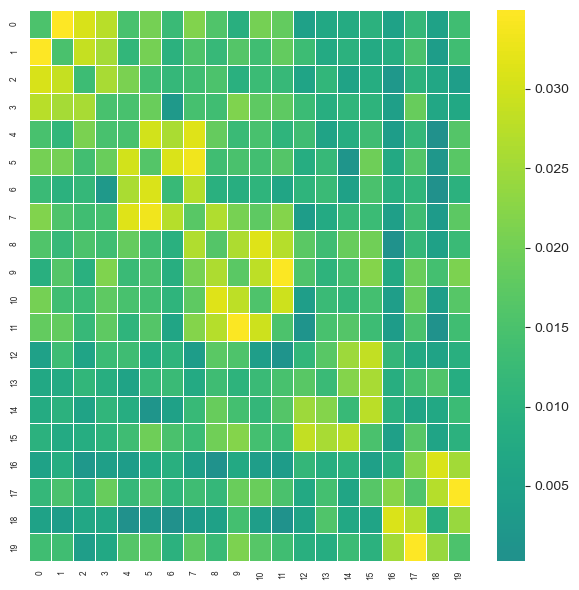

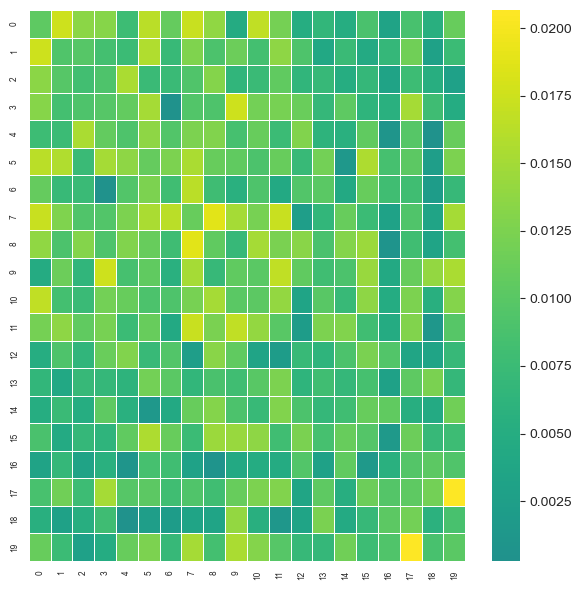

In [5]:
def get_survival_counts(pRef: PRef):
    
    univariate_count_dict = defaultdict(int)
    bivariate_count_dict = defaultdict(int)
    
    def get_rank_of_fitness(fitness):
        normal_wins = np.sum(pRef.fitness_array < fitness)
        tie_break_wins = np.sum(pRef.fitness_array == fitness) / 2
        all_wins = float(normal_wins + tie_break_wins)

        return all_wins
    
    def register_solution(row: np.ndarray, fitness):
        rank = get_rank_of_fitness(fitness)
        
        # univariate
        for a, va in enumerate(row):
            univariate_count_dict[(a, va)] += rank
        
        # bivariate
        for a, va in enumerate(row):
            for b, vb in enumerate(row[(a+1):], start=a+1):
                bivariate_count_dict[(a, b, va, vb)] += rank
    
    sorted_pRef = pRef.get_sorted(reverse=True)
    for row, fitness in zip(sorted_pRef.full_solution_matrix, sorted_pRef.fitness_array):
        register_solution(row, fitness)
    
    return univariate_count_dict, bivariate_count_dict


survival_table = np.abs(get_linkage_table_from_dicts(get_survival_counts, pRef, solution=best_solution))
presence_table = np.abs(get_linkage_table_from_dicts(get_presence_counts, pRef, solution=best_solution))
utils.show_matrix_with_colours(survival_table, fig_size=(6, 6))
utils.show_matrix_with_colours(presence_table, fig_size=(6, 6))
#utils.show_matrix_with_colours(survival_table - presence_table, fig_size=(6, 6))

for var 0, @0 -> 0.47	 0.53
for var 1, @0 -> 0.46	 0.54
for var 2, @0 -> 0.48	 0.52
for var 3, @0 -> 0.46	 0.54
for var 4, @0 -> 0.47	 0.53
for var 5, @0 -> 0.47	 0.53
for var 6, @0 -> 0.48	 0.52
for var 7, @0 -> 0.45	 0.55
for var 8, @0 -> 0.47	 0.53
for var 9, @0 -> 0.47	 0.53
for var 10, @0 -> 0.47	 0.53
for var 11, @0 -> 0.45	 0.55
for var 12, @0 -> 0.48	 0.52
for var 13, @0 -> 0.48	 0.52
for var 14, @0 -> 0.46	 0.54
for var 15, @0 -> 0.48	 0.52
for var 16, @0 -> 0.47	 0.53
for var 17, @0 -> 0.46	 0.54
for var 18, @0 -> 0.50	 0.50
for var 19, @0 -> 0.46	 0.54


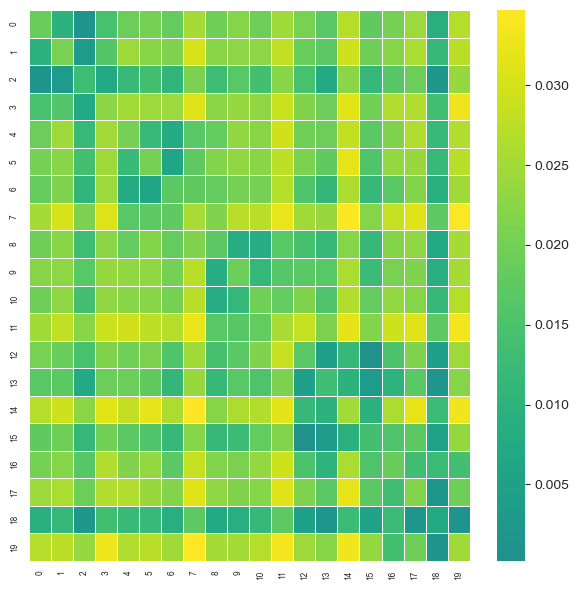

In [6]:
def combined_mutual_infos(pRef, solution):
    s_univariate_counts, s_bivariate_counts = get_survival_counts(pRef)
    r_univariate_counts, r_bivariate_counts = get_presence_counts(pRef)

    s_univariate_freqs, s_bivariate_freqs = normalise_dicts(s_univariate_counts, s_bivariate_counts, pRef.search_space)
    r_univariate_freqs, r_bivariate_freqs = normalise_dicts(r_univariate_counts, r_bivariate_counts, pRef.search_space)
    
    
    for var in every_var(pRef.search_space):
        for_zero = r_univariate_freqs[(var, 0)]
        for_one = r_univariate_freqs[(var, 1)]
        
        print(f"for var {var}, @0 -> {for_zero:.2f}\t {for_one:.2f}")
    
    c = 2
    def adjust(s, r, k):
        gamma = s / (2 * r * (1-r))
        return 2 * (1/c**k) * (1-(1/c**k)) * gamma
        #return gamma
    
    def custom_mi(a, b, va, vb):
        
        s_a = s_univariate_freqs[(a, va)]
        r_a = r_univariate_freqs[(a, va)]
        p_a = adjust(s_a, r_a, 1)
        
        s_b = s_univariate_freqs[(b, vb)]
        r_b = r_univariate_freqs[(b, vb)]
        p_b = adjust(s_b, r_b, 1)
        
        s_ab = s_bivariate_freqs[(a, b, va, vb)]
        r_ab = r_bivariate_freqs[(a, b, va, vb)]
        p_ab = adjust(s_ab, r_ab, 2)
        
        return p_ab * np.log((p_ab) / (p_a * p_b))
    
    search_space = pRef.search_space
    
    value_specific_mis = {(a, b, va, vb): custom_mi(a, b, va, vb)
                          for a, b in every_pair_of_vars(search_space)
                          for va in every_value_for_var(a, search_space)
                          for vb in every_value_for_var(b, search_space)}
    
    def mutual_information_for_variable_pair(a, b):
        return sum(value_specific_mis[(a, b, va, vb)]
                   for va in every_value_for_var(a, search_space)
                   for vb in every_value_for_var(b, search_space))
    
    variable_mis = {(a, b): mutual_information_for_variable_pair(a, b) 
                    for a, b in every_pair_of_vars(search_space)}
    
    
    if solution is None:
        return linkage_table_from_mi_dict_for_vars(variable_mis, search_space=pRef.search_space)
    else:
        return linkage_table_from_mi_dict_for_solution(value_specific_mis, solution = solution)
        
        
utils.show_matrix_with_colours(np.abs(combined_mutual_infos(pRef, solution=best_solution)), fig_size=(6, 6))